In [3]:
# TODO: llevar esto a un script .py

import os

REPO_NAME = "technical-challenge"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/enzoferrari1/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'technical-challenge'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 3), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 1.76 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/final_data.csv")

data = data.replace({True: 1, False: 0})

data = data.dropna()

<ipython-input-4-0d408b90e434>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({True: 1, False: 0})


# Desarrollo de modelos
En base al análisis realizado anteriormente, podemos proceder con el desarrollo de los modelos



## Data Split
Se decide hacer un split de 80/20

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

import numpy as np

## Modelo Base
Como mencionamos anteriormente, en base al análisis de la correlación de la variable objetivo respecto a las explicativas, un buen modelo base sería una regresión lineal respecto a la edad y la experiencia laboral

### Regresión lineal

In [6]:
def construir_pipeline(X, y, modelo=None):
    '''Devuelve una tubería para aplicar preprocesamiento y el
    modelo pasado por parámetro'''

    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', modelo)
    ])

    return pipeline

class Regresion_Lineal:
    '''Clase para entrenar un modelo de regresión lineal'''
    def __init__(self, pipeline, X_train, y_train, X_test, y_test, cv=5):
        self.pipeline = pipeline
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv = cv
        self.cv_scores = []  # Almacena los R^2 de cada fold
        self.cv_scores_mse = []  # Almacena los MSE de cada fold
        self.cv_scores_mae = []  # Almacena los MAE de cada fold

    def train_model(self):
        '''Entrena el modelo con validación cruzada y calcula las métricas
        para cada fold'''

        for i, (train_index, test_index) in enumerate(KFold(n_splits=self.cv).split(self.X_train, self.y_train)):
            X_train_fold, X_test_fold = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_fold, y_test_fold = self.y_train.iloc[train_index], self.y_train.iloc[test_index]

            self.pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = self.pipeline.predict(X_test_fold)

            r2_fold = r2_score(y_test_fold, y_pred_fold)
            mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
            mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

            self.cv_scores.append(r2_fold)
            self.cv_scores_mse.append(mse_fold)
            self.cv_scores_mae.append(mae_fold)

            print(f"\nConjunto de Validación Cruzada {i + 1}:")
            print("R^2:", round(r2_fold, 4))
            print("Error Cuadrático Medio (MSE):", round(mse_fold, 4))
            print("Error Absoluto Medio (MAE):", round(mae_fold, 4))

    def calculate_test_metrics(self):
        '''Calcula las métricas en el conjunto de prueba'''
        y_pred_test = self.pipeline.predict(self.X_test)

        r2_test = r2_score(self.y_test, y_pred_test)
        mse_test = mean_squared_error(self.y_test, y_pred_test)
        mae_test = mean_absolute_error(self.y_test, y_pred_test)

        print("\nMétricas en Conjunto de Prueba:")
        print("R^2:", round(r2_test, 4))
        print("Error Cuadrático Medio (MSE):", round(mse_test, 4))
        print("Error Absoluto Medio (MAE):", round(mae_test, 4))

        return r2_test, mse_test, mae_test

    def plot_coefficients(self):
        '''Muestra un gráfico con los coeficientes de cada variable'''
        coeficients = self.pipeline.steps[1][1].coef_.flatten()
        feature_names = self.pipeline.named_steps['preprocessor'].get_feature_names_out()

        coef_df = pd.DataFrame({'predictor': feature_names, 'coef': coeficients})

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.stem(coef_df.predictor, coef_df.coef, markerfmt=' ')
        plt.xticks(rotation=90, ha='right', size=10)
        ax.set_xlabel('feature')
        ax.set_ylabel('weights')
        ax.set_title('Parámetros del modelo')
        plt.show()

    def plot_residuals(self):
        '''Muestra un gráfico de residuos'''
        y_pred = self.pipeline.predict(self.X_test)

        fig = plt.figure(figsize=(10, 5))
        sns.histplot((self.y_test - y_pred), color="red", kde=True, stat="density", linewidth=0, bins=20)
        fig.suptitle('Análisis de Residuos', fontsize=20)
        plt.show()

    def plot_residuals_scatter(self):
        '''Muestra un gráfico personalizado de residuos'''
        y_pred = self.pipeline.predict(self.X_test)

        fig = plt.figure(figsize=(8, 4))
        fig.suptitle('Residuos')
        plt.xlabel('y_test')
        plt.ylabel('Residuos')
        plt.scatter(self.y_test, 100 * (self.y_test - y_pred) / self.y_test)
        plt.ylim(50, 120)
        plt.show()

    def plot_results(self):
        '''Muestra gráficamente los resultados de la validación cruzada'''

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot de barras para R^2
        ax1.barh(range(len(self.cv_scores)), self.cv_scores, color='skyblue', label='R^2 Score')
        ax1.set_yticks(range(len(self.cv_scores)))
        ax1.set_yticklabels([f'Fold {i+1}' for i in range(len(self.cv_scores))])
        ax1.set_xlabel('R^2 Score')
        ax1.set_title('Resultados de Validación Cruzada (R^2)')

        # Plot de barras para MSE
        ax2.barh(range(len(self.cv_scores_mse)), self.cv_scores_mse, color='orange', label='MSE')
        ax2.set_yticks(range(len(self.cv_scores_mse)))
        ax2.set_yticklabels([f'Fold {i+1}' for i in range(len(self.cv_scores_mse))])
        ax2.set_xlabel('MSE')
        ax2.set_title('Resultados de Validación Cruzada (MSE)')

        plt.show()

    def plot_test_pred(self):
        '''Muestra un gráfico valores reales vs predicciones'''

        y_pred = self.pipeline.predict(self.X_test)

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.scatter(self.y_test, y_pred)
        ax.set_xlabel('Valores Reales')
        ax.set_ylabel('Predicciones')
        ax.set_title('Valores Reales vs. Predicciones')

        # Línea diagonal
        diagonal = np.linspace(min(self.y_test.min(), y_pred.min()), max(self.y_test.max(), y_pred.max()))
        ax.plot(diagonal, diagonal, '-r')

        plt.show()

    def get_processed_data(self):
        '''Obtiene los conjuntos de entrenamiento y prueba procesados por la tubería'''
        X_train_transformed = self.pipeline.named_steps['preprocessor'].transform(self.X_train)
        X_test_transformed = self.pipeline.named_steps['preprocessor'].transform(self.X_test)

        return X_train_transformed, X_test_transformed, self.y_train, self.y_test

In [7]:
X1 = data[['Age', 'Years of Experience']]
y1 = data['Salary']

regresion_pipe1 = construir_pipeline(X1, y1, modelo=LinearRegression())
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

regresion_trainer1 = Regresion_Lineal(regresion_pipe1, X_train1, y_train1, X_test1, y_test1)
regresion_trainer1.train_model() #metricas para cada fold
regresion_trainer1.calculate_test_metrics() #metricas para el conjunto de prueba


Conjunto de Validación Cruzada 1:
R^2: 0.845
Error Cuadrático Medio (MSE): 338554775.5818
Error Absoluto Medio (MAE): 12599.83

Conjunto de Validación Cruzada 2:
R^2: 0.8092
Error Cuadrático Medio (MSE): 404472267.4498
Error Absoluto Medio (MAE): 13504.8586

Conjunto de Validación Cruzada 3:
R^2: 0.879
Error Cuadrático Medio (MSE): 325882646.8447
Error Absoluto Medio (MAE): 12807.4182

Conjunto de Validación Cruzada 4:
R^2: 0.9084
Error Cuadrático Medio (MSE): 222816642.3146
Error Absoluto Medio (MAE): 10947.065

Conjunto de Validación Cruzada 5:
R^2: 0.8657
Error Cuadrático Medio (MSE): 277235916.1009
Error Absoluto Medio (MAE): 12820.0182

Métricas en Conjunto de Prueba:
R^2: 0.8767
Error Cuadrático Medio (MSE): 292899745.0625
Error Absoluto Medio (MAE): 13056.7791


(0.8767088402091628, 292899745.06251055, 13056.779107528106)

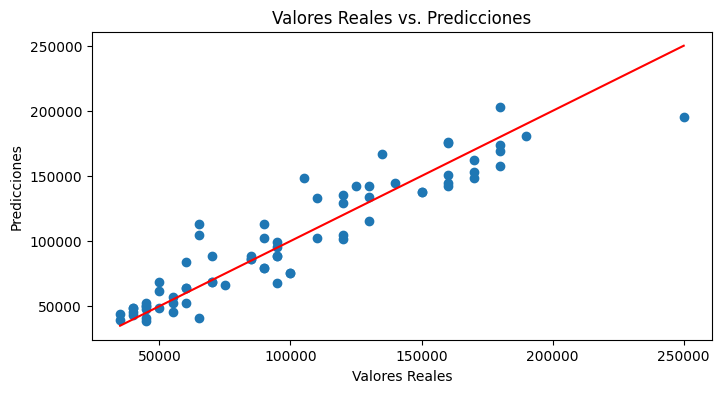

In [8]:
regresion_trainer1.plot_test_pred()

### Métricas y resultados

Usamos el R2 como métrica, y observamos también el MAE. De esta manera, observamos la variabilidad que está siendo explicada por las variables explicativas y el desvío que tienen las predicciones sobre los valores reales. Notamos que, a pesar de estar usando un modelo base, obtenemos buenas métricas: un R2 de 0.87 y un MSE de 13000. Además, notamos una dispersión uniforme en el gráfico de valores reales / predicciones, por lo que, a pesar de que contamos con un modelo base, contamos con una muy buena generalización.

Busquemos mejorarlas utilizando otros tipos de modelos y todos los datos


## Modelo
Resulta tentador utilizar una regresión lineal utilizando todas las variables, sin embargo, a pesar de haber observado una linearidad en campos como género o título de educación, la vectorización del campo Job Title requiere modelos más complejos para poder capturar las distintas combinaciones.

Por esto, se proponen distintos tipos de modelos a utilizar:
- Regresión mediante Random Forest: Los arboles de decisión tienen la ventaja de brindar una buena explicatibilidad (aunque aplicar métodos de ensamble suele complicar esto). Usar métodos de ensamble y grid search nos facilita llegar a una mejor robustez.
- Redes neuronales densas

Se puede analizar la explicatibilidad de las variables en ambos modelos usando SHAP.

Se decide primero optar por la primera opción.



### Random Forest
Recordemos que dejamos pendiente la estandarización de los datos. Se hizo teniendo en mente que el objetivo sería usar un árbol de decisión. Este tipo de modelos no requieren estandarización, por lo que se decide no estandarizar. Sin embargo, hubiese resultado conveniente estandarizar para poder interpretar los coeficientes del modelo de regresión lineal


In [9]:
X1 = data.drop(columns=["Salary"])
y1 = data['Salary']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Specify the parameter grid
param_grid = {'n_estimators': [20, 30, 35, 40, 45, 50, 55, 60],
              'max_depth': [5, 6, 7, 10, 15, 20, 25, 30, 35, 40],
}

# Initialize the model
rf = RandomForestRegressor()

# Scorer for determining the metric to optimize (negative mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearchCV for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train2, y_train2)

# Get the best estimator from the grid search
best_rf_regressor = grid_search.best_estimator_

# Predictions on the test set
y_pred_rf = best_rf_regressor.predict(X_test2)

# Best parameters found
print(f"Best number of estimators: {grid_search.best_params_['n_estimators']}")
print(f"Best maximum tree depth: {grid_search.best_params_['max_depth']}")
print("Results for the best model:")

# Evaluation (Mean Squared Error)
print("R2 score:", r2_score(y_test2, y_pred_rf))
print("MAE:", mean_absolute_error(y_test2, y_pred_rf))



Best number of estimators: 40
Best maximum tree depth: 20
Results for the best model:
R2 score: 0.9310300471588749
MSE: 163850203.35935107
MAE: 7784.075126262627


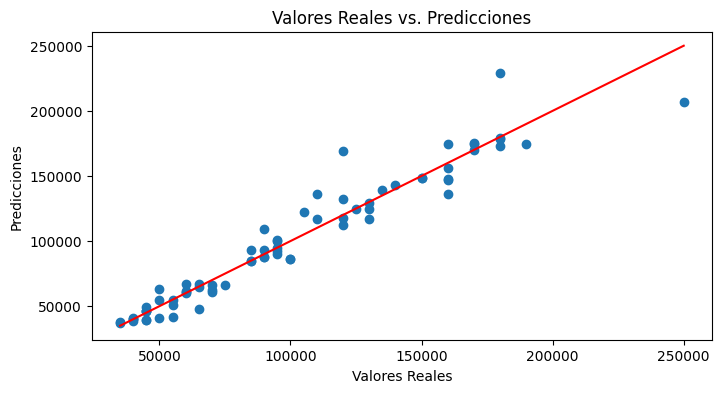

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_test2, y_pred_rf)
ax.set_xlabel('Valores Reales')
ax.set_ylabel('Predicciones')
ax.set_title('Valores Reales vs. Predicciones')

# Línea diagonal
diagonal = np.linspace(min(y_test2.min(), y_pred_rf.min()), max(y_test2.max(), y_pred_rf.max()))
ax.plot(diagonal, diagonal, '-r')

plt.show()

### Métricas y resultados
Se han obtenido resultados muchísimo mejores producto de elegir un modelo más complejo y las variables categóricas. un incremento del R2 a 0.93 y un MAE de 7700 implican predicciones más precisas. Analizando el grafico de valores reales vs predicciones observamos ahora una dispersión aún menor comparado con la regresión lineal.



## Explicatibilidad: SHAP
Modelos más complejos como Random Forest no tienen coeficientes interpretables como la regresión lineal. Sin embargo, el método SHAP permite brindar explicatibilidad a los modelos analizando los "aportes" que le da cada variable a cada predicción. Limitemonos a revisar el beeswarm plot

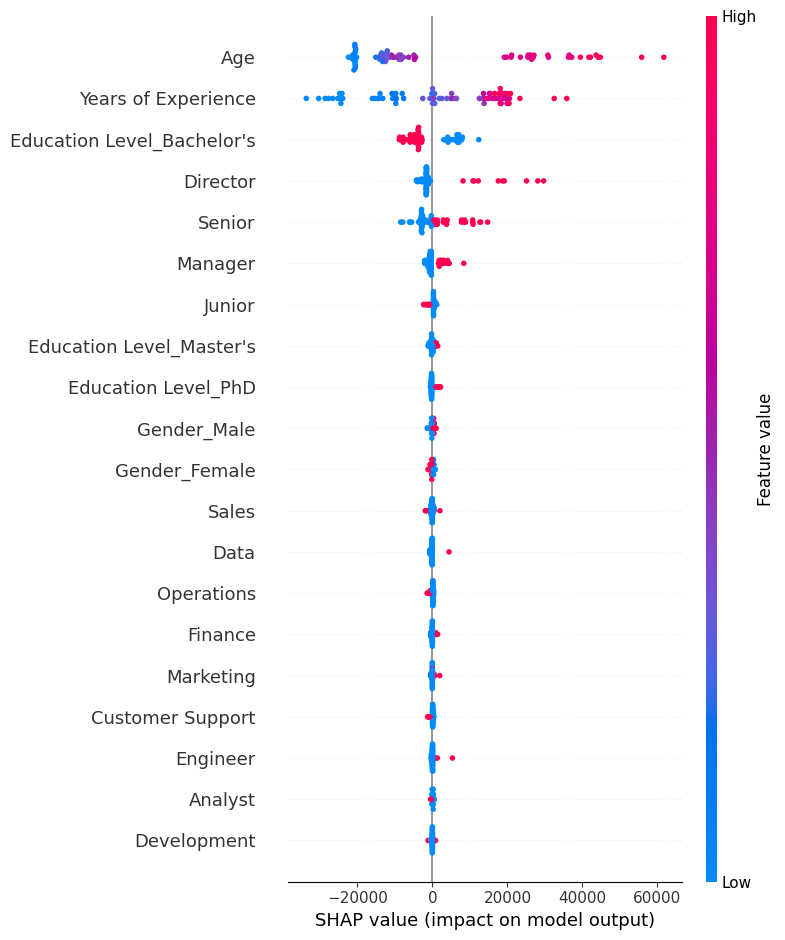

In [28]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.Explainer(best_rf_regressor, X_train2)

# Calculate SHAP values for the test set
shap_values = explainer(X_test2)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test2)

Observamos el gráfico de las variables ordenadas según cuales fueron las que más impacto tuvieron en el modelo. También podemos saber si cada variable tuvo un impacto positivo o negativo en las predicciones. Podemos tomar las siguientes conclusiones:

- La edad y experiencia siguen siendo las variables que mayormente explican el salario, siendo más clara la experiencia: a mayor experiencia, mayor salario.
- El próximo mejor explicador es el título, al parecer tener título de Bachelor comparado con Máster o Phd impacta negativamente.
- Estar en una posición de Director (ver feature engineering) tiene un impacto considerable (aunque no tenerlo no tiene mucho impacto).
- Las próximas tres variables son Senior, Manager y Junior, las cuales se comportan como uno esperan.

El resto de variables tienen un impacto menor, lo cual puede deberse a la falta de datos de estas columnas.

Concluyamos la explicatibilidad del modelo viendo el gráfico de barras de la media del valor absoluto de los shap values. Esto marca solamente las variables que mayor explican el modelo.

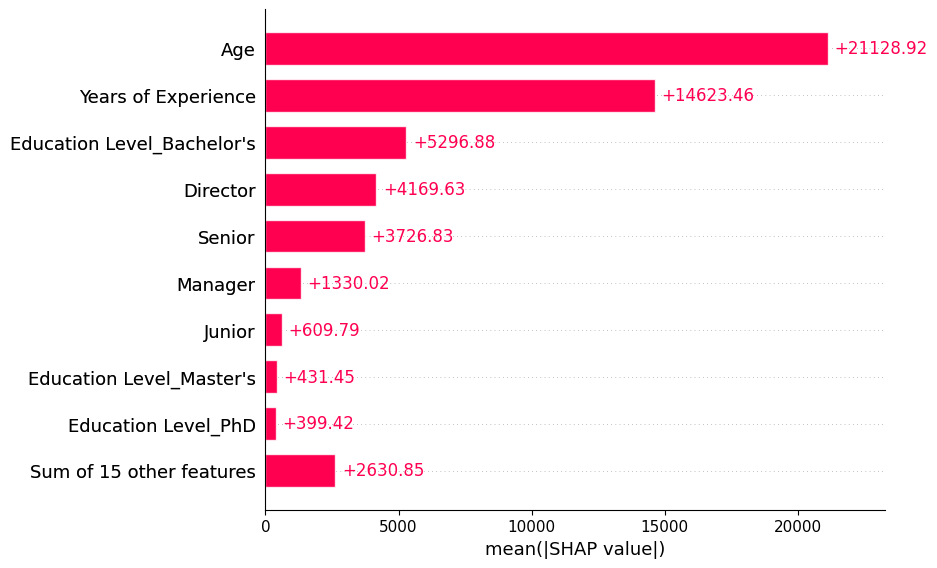

In [30]:
shap.plots.bar(shap_values)

In [32]:
data.columns

Index(['Age', 'Years of Experience', 'Salary', 'Finance', 'HR', 'Marketing',
       'Sales', 'Customer Support', 'Operations', 'Data', 'Analyst',
       'Scientist', 'Project', 'Product', 'Engineer', 'Development', 'Junior',
       'Senior', 'Director', 'Manager', 'Gender_Female', 'Gender_Male',
       'Education Level_Bachelor's', 'Education Level_Master's',
       'Education Level_PhD'],
      dtype='object')